<a href="https://colab.research.google.com/github/NigarSultana156/499A/blob/main/SentimentAnlysisWithXAI%2BBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Required Libraries


In [ ]:
!pip install transformers torch torch-optimizer imbalanced-learn scikit-learn matplotlib --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.9 MB/s eta 0:00:00


#2. Load and Preprocess The Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your scraped data from the provided URL
url = "https://raw.githubusercontent.com/amanullahshah32/Review-Scraping/refs/heads/main/Dataset/cleaned_dataset.csv"
df = pd.read_csv(url)

# Drop rows where 'review_description' or 'rating' are missing
df.dropna(subset=['review_description', 'rating'], inplace=True)

# Sample 2,000 rows randomly
df = df.sample(n=2000, random_state=42)

# Shuffle the sampled dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a sentiment column based on rating (1-2 -> Negative, 3 -> Neutral, 4-5 -> Positive)
df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['review_description'], df['sentiment'], test_size=0.2, random_state=42)

# Convert labels to list
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()

# Display the first few rows of the shuffled dataset
print(df.head())



        source                             review_id      user_name  \
0  Google Play  fa58c5fd-ee4a-40c1-8a33-8950cf7e0045  A Google user   
1  Google Play  ef75a075-533e-4c78-935a-3b0535e22db0  A Google user   
2  Google Play  91398dea-626b-4f9f-8d0c-4558f2263020  A Google user   
3  Google Play  5646b37f-e24c-4d8f-94e0-096e31f08bf5  A Google user   
4  Google Play  e165098c-75d7-410f-ae9a-f8140b145d9f  A Google user   

   review_title                                 review_description  rating  \
0           NaN  I  just  started  using  it  but  I  am  alrea...       4   
1           NaN                       very iseful app in medicine.       5   
2           NaN      Helps a lot with not smoking. Fills the void.       5   
3           NaN  Makes tracking my medical lifestyle easier. Do...       5   
4           NaN                       Really good for med students       5   

   thumbs_up          review_date developer_response developer_response_date  \
0          0  2016-03-02

#3.Handle Class Imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Since train_texts is a pandas Series, we need to reshape it to a DataFrame
train_texts_df = pd.DataFrame(train_texts)

# Apply oversampling to balance the classes
train_texts_resampled, train_labels_resampled = ros.fit_resample(train_texts_df, train_labels)

# Convert the DataFrame of resampled texts back to a list
train_texts_resampled = train_texts_resampled.squeeze().tolist()  # .squeeze() ensures a flat list


#4. Tokenization with BERT

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(train_texts_resampled, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#5. Create a Dataset Class for PyTorch

In [ ]:
import torch
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the PyTorch datasets
train_dataset = ReviewDataset(train_encodings, train_labels_resampled)
val_dataset = ReviewDataset(val_encodings, val_labels)


#6. Load Pre-trained BERT Model

In [ ]:
import torch
from transformers import BertForSequenceClassification

# Define the device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained BERT model for sequence classification (3 classes)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Move the model to the appropriate device
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#7. Set Up DataLoader, Optimizer, and Scheduler

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Optimizer: AdamW with weight decay and a smaller learning rate
learning_rate = 3e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Scheduler for learning rate decay
epochs = 5
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#8. Class Weights for Imbalance

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Convert the class labels to a NumPy array
classes = np.array([0, 1, 2])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels_resampled)

# Convert to a PyTorch tensor and move it to the appropriate device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use the weights in the loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


#9. Training Loop

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1 completed in 77.80 seconds
Training Accuracy: 0.7684
Validation Accuracy: 0.8825
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.73      0.90      0.81        40
           1       0.14      0.31      0.19        13
           2       0.97      0.90      0.94       347

    accuracy                           0.88       400
   macro avg       0.61      0.70      0.65       400
weighted avg       0.92      0.88      0.90       400



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2 completed in 78.72 seconds
Training Accuracy: 0.9628
Validation Accuracy: 0.8975
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.84      0.78      0.81        40
           1       0.18      0.31      0.23        13
           2       0.95      0.93      0.94       347

    accuracy                           0.90       400
   macro avg       0.66      0.67      0.66       400
weighted avg       0.91      0.90      0.91       400



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3 completed in 78.70 seconds
Training Accuracy: 0.9759
Validation Accuracy: 0.8900
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.72      0.82      0.77        40
           1       0.19      0.31      0.24        13
           2       0.96      0.92      0.94       347

    accuracy                           0.89       400
   macro avg       0.62      0.68      0.65       400
weighted avg       0.91      0.89      0.90       400



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4 completed in 78.79 seconds
Training Accuracy: 0.9808
Validation Accuracy: 0.8950
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.79      0.85      0.82        40
           1       0.17      0.31      0.22        13
           2       0.96      0.92      0.94       347

    accuracy                           0.90       400
   macro avg       0.64      0.69      0.66       400
weighted avg       0.92      0.90      0.91       400



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5 completed in 78.83 seconds
Training Accuracy: 0.9798
Validation Accuracy: 0.9025
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.79      0.85      0.82        40
           1       0.19      0.31      0.24        13
           2       0.96      0.93      0.95       347

    accuracy                           0.90       400
   macro avg       0.65      0.70      0.67       400
weighted avg       0.92      0.90      0.91       400



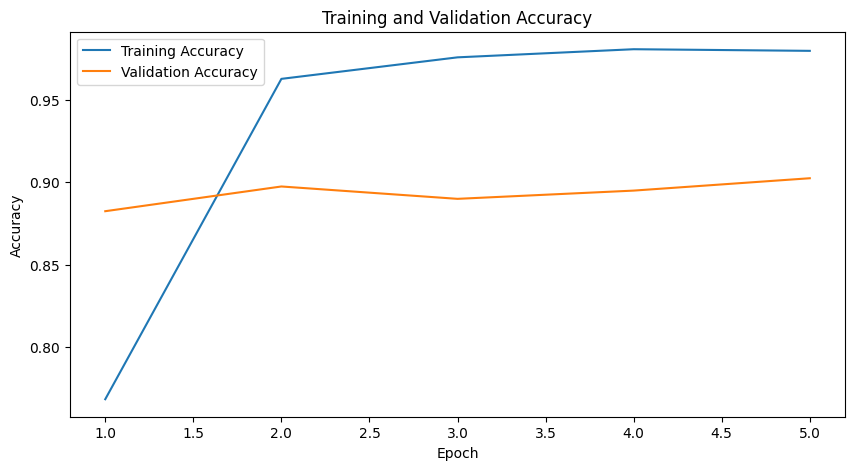

In [ ]:
import time
import torch
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Initialize lists to track metrics
train_accuracies = []
val_accuracies = []
epoch_durations = []

# Loop for training and validation
for epoch in range(5):  # Training for 10 epochs
    start_time = time.time()  # Start time for the epoch

    # Training loop
    model.train()
    train_preds = []
    train_labels_epoch = []  # Track labels for each epoch
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Collect predictions
        train_preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
        train_labels_epoch.extend(batch['labels'].cpu().numpy())

    end_time = time.time()  # End time for the epoch
    epoch_duration = end_time - start_time  # Time taken for the epoch
    epoch_durations.append(epoch_duration)

    # Calculate training accuracy
    train_acc = accuracy_score(train_labels_epoch, train_preds)
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())

    # Calculate validation accuracy
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1} completed in {epoch_duration:.2f} seconds')
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Validation Accuracy: {val_acc:.4f}')

    # Classification report
    print(f'Classification Report (Validation):\n {classification_report(val_labels, val_preds)}')

epochs = 5

# Visualize the results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#10. Make New Predictions

In [ ]:
# Make predictions on new data (Example: a list of review texts)
new_reviews = [
    "The app is very helpful for tracking my health.",
    "I had a bad experience, it kept crashing.",
    "Great app, I would definitely recommend it to others!"
]

# Tokenize the new reviews
new_encodings = tokenizer(new_reviews, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Move the tensors to the appropriate device
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Perform the prediction
model.eval()
with torch.no_grad():
    outputs = model(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

# Print the predictions (0 = Negative, 1 = Neutral, 2 = Positive)
for review, pred in zip(new_reviews, predictions):
    sentiment = ['Negative', 'Neutral', 'Positive'][pred]
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: The app is very helpful for tracking my health.
Predicted Sentiment: Positive

Review: I had a bad experience, it kept crashing.
Predicted Sentiment: Negative

Review: Great app, I would definitely recommend it to others!
Predicted Sentiment: Positive



In [ ]:
import os

# Define the save directory
save_directory = "./saved_bert_model"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to ./saved_bert_model


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the model and tokenizer
loaded_model = BertForSequenceClassification.from_pretrained(save_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [ ]:
!pip install shap


#11. SHAP for Model Explanation

In [ ]:
import shap
import torch
from transformers import BertTokenizer

# Ensure the model is in evaluation mode and on the correct device (GPU if available)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a function for tokenizing text
def tokenize_text(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),  # Ensure texts are in the correct format
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenizer instance
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# A wrapper function for SHAP to pass through the model
def predict(texts):
    inputs = tokenize_text(texts, tokenizer)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Ensure inputs are on the same device as the model
    with torch.no_grad():
        outputs = model(**inputs)
        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

# SHAP Explainer setup
explainer = shap.Explainer(predict, tokenizer)

# Select a few samples from your validation set to explain
texts_to_explain = [str(text) for text in val_texts[:5]]  # Explicitly ensure a list of strings
shap_values = explainer(texts_to_explain)

# Visualize the explanations
for i, text in enumerate(texts_to_explain):
    print(f"\n--- Explanation for Text {i+1}: ---")
    print(text)
    shap.text_plot(shap_values[i])


PartitionExplainer explainer: 6it [00:13, 13.55s/it]               


--- Explanation for Text 1: ---
It is very nice apps and very good functional. I am very glad



--- Explanation for Text 2: ---
this app is very fast i like and so good app other app comper is so fast



--- Explanation for Text 3: ---
easy to use very helpful



--- Explanation for Text 4: ---
Wonderful app if you want some encouragement with quitting.



--- Explanation for Text 5: ---
Really Good.... I'm really dependant on it...lol


#12. LIME for Model Explanation

In [ ]:
import lime
from lime.lime_text import LimeTextExplainer

# Initialize a LIME text explainer
explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])

# Define a function for predicting class probabilities using the BERT model
def predict_proba(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        logits = model(**encodings).logits
        probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()
    return probs

# Choose a sample review from the validation set
sample_review = val_texts[0]

# Explain the prediction for the sample review using LIME
lime_explanation = explainer.explain_instance(sample_review, predict_proba, num_features=10)

# Visualize the LIME explanation
lime_explanation.show_in_notebook(text=True)
